## Modelo LUR

Fusion inicial:
                    Estaci√≥n                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
2  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
3  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
4  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   

                   date    PM25  Humidity  Temperature  
0  2025-03-01T01:00:00Z  17.745    77.936        18.17  
1  2025-03-01T02:00:00Z  18.760    78.760        18.00  
2  2025-03-01T03:00:00Z  13.200    80.000        18.00  
3  2025-03-01T04:00:00Z     NaN       NaN          NaN  
4  2025-03-01T05:00:00Z  13.000    80.000        18.00  
Tras separar coordenadas:
                    Estaci√≥n                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.56525

/tmp/ipykernel_3339/3054377111.py:119: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hotspots.plot(ax=ax, color="crimson", markersize=100, label="Hotspots High‚ÄìHigh")


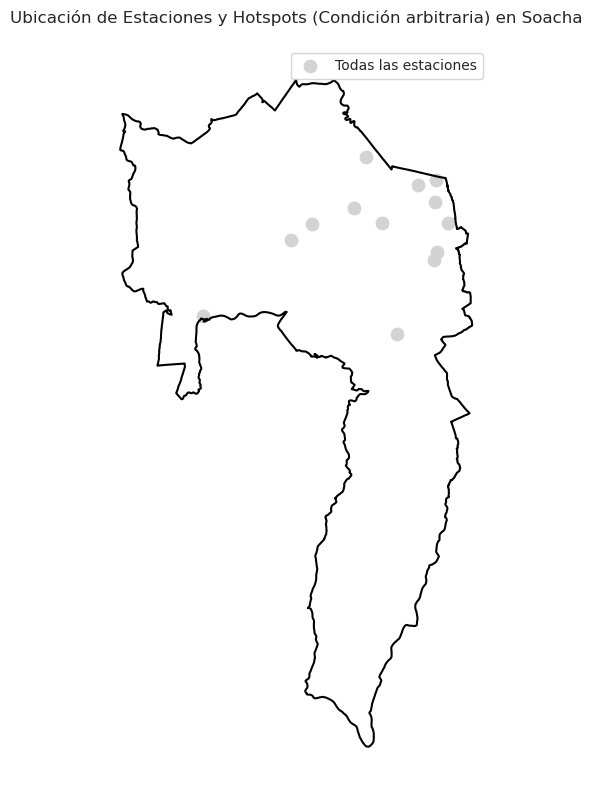

Moran‚Äôs I Global para PM2.5: -0.1987
p-valor (normal) Global: 0.3567


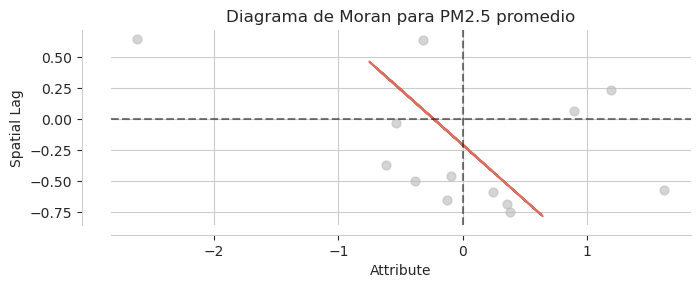

                          Estaci√≥n  PM25_mean  lisa_q  lisa_type  lisa_p
0        SAM_IE_BuenosAires_306e73  12.188792       3    Low‚ÄìLow   0.429
1             SAM_IE_Cazuca_7f4c00  20.338745       1  High‚ÄìHigh   0.227
2             SAM_IE_Chiloe_6eeafa  14.129366       3    Low‚ÄìLow   0.099
3        SAM_IE_ElCharquito_3075d1  18.937467       1  High‚ÄìHigh   0.413
4         SAM_IE_ElProgreso_1c4cc9  22.345122       4   High‚ÄìLow   0.184
5            SAM_IE_Fusunga_4d410c  14.268714       3    Low‚ÄìLow   0.201
6   SAM_IE_GeneralSantander_edee42  16.486133       4   High‚ÄìLow   0.078
7         SAM_IE_LaDespensa_7c0276  15.863100       4   High‚ÄìLow   0.140
8           SAM_IE_LeonXIII_fb3f2c  11.790557       3    Low‚ÄìLow   0.211
9    SAM_IE_LuisCarlosGalan_e38027  13.215638       2   Low‚ÄìHigh   0.082
10    SAM_IE_NuevoCompartir_fc04d7  12.914084       3    Low‚ÄìLow   0.159
11     SAM_IE_PazyEsperanza_f36757  16.399616       4   High‚ÄìLow   0.106
12          SAM_IE_Ricaurt

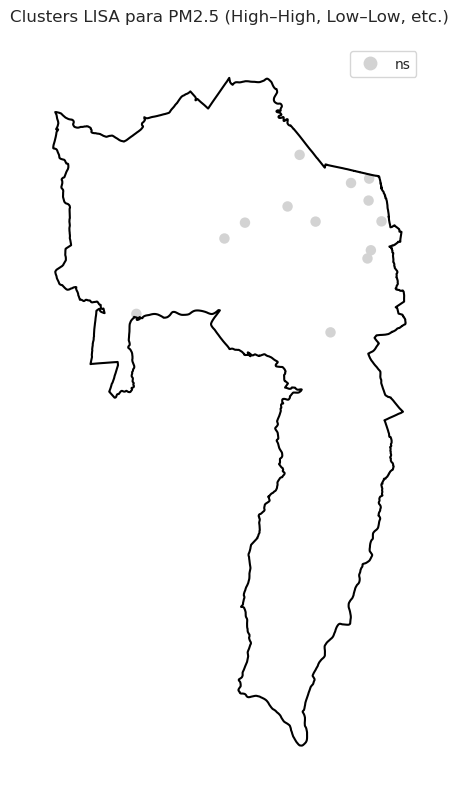


N√∫mero de estaciones en High‚ÄìHigh (hotspots) significativos: 0
Empty DataFrame
Columns: [Estaci√≥n, PM25_mean, lisa_p]
Index: []
                            OLS Regression Results                            
Dep. Variable:              PM25_mean   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     5.259
Date:                Mon, 23 Jun 2025   Prob (F-statistic):             0.0364
Time:                        01:44:11   Log-Likelihood:                -24.897
No. Observations:                  11   AIC:                             59.79
Df Residuals:                       6   BIC:                             61.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t    

/opt/miniconda/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [7]:
# =============================================================================
# 0. Importar Librer√≠as
# =============================================================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Para manejo de rutas
from pathlib import Path
from shapely.geometry import Point

# Para an√°lisis de series temporales (si se requiere)
import statsmodels.tsa.stattools as ts
from scipy.stats import pearsonr

# Para an√°lisis espacial
import libpysal as ps
from esda import Moran, Moran_Local, Moran_BV
from splot.esda import moran_scatterplot, lisa_cluster

# Para regresi√≥n espacial (modelo LUR)
import statsmodels.formula.api as smf

# =============================================================================
# 1. Cargar datos y prepararlos
# =============================================================================
# Rutas a los archivos
root_folder = "/notebooks/"
MON_path = root_folder + "data_MAR_1.csv"              # Datos de monitoreo de sensores
excel_path = root_folder + "Coordenadas_Instituciones.xlsx"   # Coordenadas de instituciones (estaciones)
SHAPE_MUN = root_folder + "municipios_colombia.shp"         # Shapefile de municipios
SHAPE_REDVIAL = root_folder + "RedVial.shp"                 # Shapefile de red vial
SHAPE_SUELO = root_folder + "Usos_Suelo_Urbano_POT._Municipio_de_Soacha._2000_(capa).shp"  # Capa de Uso del suelo

# Cargar shapefiles de l√≠mite municipal, red vial y capa de suelo
gdf_mun = gpd.read_file(SHAPE_MUN)
gdf_road = gpd.read_file(SHAPE_REDVIAL)
gdf_suelo = gpd.read_file(SHAPE_SUELO)

# Cargar coordenadas y datos de monitoreo
df_coord = pd.read_excel(excel_path, sheet_name="Hoja1")
df_moni = pd.read_csv(MON_path)

# Asegurarse de que la columna de estaci√≥n tenga el nombre correcto
df_moni.rename(columns={"station": "Estaci√≥n"}, inplace=True)

# Fusionar las tablas por la columna ‚ÄúEstaci√≥n‚Äù
datos_combinados = pd.merge(df_coord, df_moni, on="Estaci√≥n", how="inner")
print("Fusion inicial:")
print(datos_combinados.head())

# Separar la columna 'Coordenadas' en 'Latitud' y 'Longitud'
datos_combinados[['Latitud', 'Longitud']] = datos_combinados['Coordenadas'].str.split(',', expand=True)
# Quitar espacios en blanco y convertir a float
datos_combinados['Latitud'] = datos_combinados['Latitud'].astype(float)
datos_combinados['Longitud'] = datos_combinados['Longitud'].astype(float)

print("Tras separar coordenadas:")
print(datos_combinados.head())
print("Columnas disponibles:", list(datos_combinados.columns))

# =============================================================================
# 2. Generar el GeoDataFrame de Estaciones (resumen por estaci√≥n)
# =============================================================================
# Supongamos que df_moni tiene lecturas diarias y ya se han agregado por estaci√≥n.
# Aqu√≠ usamos station_summary que ya calcul√≥ estad√≠sticas (por ejemplo, PM2.5, Humedad, Temperatura).
station_summary = df_moni.groupby("Estaci√≥n").agg({
    "PM25": ["mean", "std", "min", "max"],
    "Humidity": ["mean", "std", "min", "max"],
    "Temperature": ["mean", "std", "min", "max"]
}).reset_index()
# Aplanar nombres de columnas del MultiIndex
station_summary.columns = [
    "Estaci√≥n",
    "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
    "Humidity_mean", "Humidity_std", "Humidity_min", "Humidity_max",
    "Temperature_mean", "Temperature_std", "Temperature_min", "Temperature_max"
]

print("\nResumen estad√≠stico por estaci√≥n:")
print(station_summary.head())

# Extraer las coordenadas √∫nicas (por estaci√≥n) desde datos_combinados
coord_estaciones = datos_combinados[["Estaci√≥n", "Latitud", "Longitud"]].drop_duplicates()
# Fusionar con el resumen por estaci√≥n
gdf_est = station_summary.merge(coord_estaciones, on="Estaci√≥n")
# Crear la geometr√≠a: cada estaci√≥n se representa como un punto
geometry = [Point(xy) for xy in zip(gdf_est["Longitud"], gdf_est["Latitud"])]
gdf_est = gpd.GeoDataFrame(gdf_est, geometry=geometry, crs="EPSG:4326")

# Proyectar al CRS que desees; en este caso a EPSG:9377 (MAGNA-SIRGAS, apropiado para datos en Bogot√°/Soacha)
gdf_est = gdf_est.to_crs(epsg=9377)

# Tambi√©n, proyectar los shapefiles de Soacha (municipios), red vial y suelo a EPSG:9377:
gdf_mun = gdf_mun.to_crs(epsg=9377)
gdf_road = gdf_road.to_crs(epsg=9377)
gdf_suelo = gdf_suelo.to_crs(epsg=9377)

# =============================================================================
# 3. Visualizaci√≥n de estaciones sobre el mapa del municipio de Soacha
# =============================================================================
# Filtrar el municipio de Soacha (ajusta el nombre seg√∫n tu shapefile)
gdf_soacha = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper() == "SOACHA"]

fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar el contorno del municipio (l√≠mites)
gdf_soacha.boundary.plot(ax=ax, color="black")
# Graficar todas las estaciones en gris claro
gdf_est.plot(ax=ax, color="lightgray", markersize=80, label="Todas las estaciones")
# Destacar las estaciones hotspots (m√°s adelante se definir√°n)
# Por ahora, asumiremos que la variable 'hotspots' se ha calculado.
# Si a√∫n no lo hacemos, se puede crear una m√°scara vac√≠a o repetir gdf_est (para ilustraci√≥n)
# En este ejemplo, definimos hotspots como estaciones con PM2.5_mean superior a un umbral arbitrario (por ejemplo, > 25)
hotspots = gdf_est[gdf_est["PM25_mean"] > 25]  # Ejemplo; ajustar seg√∫n tus datos
hotspots.plot(ax=ax, color="crimson", markersize=100, label="Hotspots High‚ÄìHigh")

# Etiquetar las estaciones hotspots
for x, y, label in zip(hotspots.geometry.x, hotspots.geometry.y, hotspots["Estaci√≥n"]):
    ax.text(x, y, label, fontsize=9, ha="right")

ax.set_title("Ubicaci√≥n de Estaciones y Hotspots (Condici√≥n arbitraria) en Soacha")
ax.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

# =============================================================================
# 4. An√°lisis espacial: C√°lculo del √≠ndice de Moran Global y Local (LISA)
# =============================================================================
# Crear matriz de pesos (KNN, k=4) para las estaciones
coords = np.array(list(zip(gdf_est.geometry.x, gdf_est.geometry.y)))
knn_w = ps.weights.KNN.from_array(coords, k=4)
knn_w.transform = "R"  # Normalizamos fila a fila

# Calcular el √≠ndice de Moran Global para PM2.5
moran_pm = Moran(gdf_est["PM25_mean"], knn_w)
print(f"Moran‚Äôs I Global para PM2.5: {moran_pm.I:.4f}")
print(f"p-valor (normal) Global: {moran_pm.p_norm:.4f}")

# Diagrama de dispersi√≥n de Moran
fig, ax = moran_scatterplot(moran_pm, aspect_equal=True)
ax.set_title("Diagrama de Moran para PM2.5 promedio")
plt.tight_layout()
plt.show()

# Calcular el √≠ndice Local de Moran (LISA)
lisa = Moran_Local(gdf_est["PM25_mean"], knn_w)

# Agregar resultados LISA al GeoDataFrame
gdf_est["lisa_q"] = lisa.q  # Determina los cuadrantes: 1=High‚ÄìHigh, 2=Low‚ÄìHigh, 3=Low‚ÄìLow, 4=High‚ÄìLow
gdf_est["lisa_p"] = lisa.p_sim  # p-value local

# Crear una columna categ√≥rica interpretativa
gdf_est["lisa_type"] = gdf_est["lisa_q"].map({
    1: "High‚ÄìHigh",
    2: "Low‚ÄìHigh",
    3: "Low‚ÄìLow",
    4: "High‚ÄìLow"
})
print(gdf_est[["Estaci√≥n", "PM25_mean", "lisa_q", "lisa_type", "lisa_p"]])

# Visualizar el mapa LISA
fig, ax = plt.subplots(figsize=(10, 8))
lisa_cluster(lisa, gdf_est, p=0.05, ax=ax, legend=True)
gdf_soacha.boundary.plot(ax=ax, color="black")
ax.set_title("Clusters LISA para PM2.5 (High‚ÄìHigh, Low‚ÄìLow, etc.)")
plt.tight_layout()
plt.show()

# Contar el n√∫mero de Hotspots (High‚ÄìHigh) significativos (p < 0.05)
hotspots = gdf_est[(gdf_est["lisa_q"] == 1) & (gdf_est["lisa_p"] < 0.05)]
print(f"\nN√∫mero de estaciones en High‚ÄìHigh (hotspots) significativos: {len(hotspots)}")
print(hotspots[["Estaci√≥n", "PM25_mean", "lisa_p"]])

# =============================================================================
# 5. Construcci√≥n del modelo LUR
# =============================================================================
# Para el modelo LUR usaremos variables de la estaci√≥n:
# - PM2.5 promedio (variable dependiente)
# - Temperature_mean y Humidity_mean (variables explicativas)
# Adem√°s, incorporamos indicadores derivados de capas:
# (a) Informaci√≥n de uso del suelo: se hace un spatial join con gdf_suelo.
gdf_est = gpd.sjoin(gdf_est, gdf_suelo[["USO_SUELO", "geometry"]], how="left", predicate="within")

# (b) Distancia a la red vial: calcular la distancia a la carretera m√°s cercana.
# Esta es una forma sencilla de obtener un predictor derivado de la red vial.
gdf_est["dist_road"] = gdf_est.geometry.apply(lambda geom: gdf_road.distance(geom).min())

# Crear un DataFrame para modelo LUR con las variables necesarias.
df_model = gdf_est[["PM25_mean", "Temperature_mean", "Humidity_mean", "USO_SUELO", "dist_road"]].copy()
# Convertir uso_suelo a variable categ√≥rica, si a√∫n no lo es.
df_model["uso_suelo"] = df_model["USO_SUELO"].astype("category")

# Ajustar el modelo LUR (OLS)
model = smf.ols("PM25_mean ~ Temperature_mean + Humidity_mean + dist_road + C(USO_SUELO)", data=df_model).fit()
print(model.summary())

# Evaluar los residuos del modelo con Moran‚Äôs I para ver si quedan patrones espaciales significativos.
df_model["resid"] = model.resid
# Recalcular pesos espaciales sobre las mismas coordenadas
coords = np.array(list(zip(gdf_est.geometry.x, gdf_est.geometry.y)))
knn_w = ps.weights.KNN.from_array(coords, k=4)
knn_w.transform = "R"

moran_resid = Moran(df_model["resid"], knn_w)
print(f"\nMoran‚Äôs I para los residuos del modelo: {moran_resid.I:.4f}")
print(f"p-valor (residuos): {moran_resid.p_norm:.4f}")

# =============================================================================
# Interpretaci√≥n final
# =============================================================================
# Si el modelo LUR presenta:
# - Buen ajuste en el summary (coeficientes significativos, R2 adecuado).
# - Los residuos no muestran autocorrelaci√≥n espacial significativa (Moran p-value >= 0.05),
# entonces puedes justificar un LUR "puro".
# En cambio, si quedara autocorrelaci√≥n espacial en los residuos, se deber√≠a considerar 
# incorporar estructuras espaciales adicionales (por ejemplo, un modelo de Spatial Lag o GWR).

Se resumen dos aspectos importantes en el an√°lisis de un modelo de regresi√≥n espacial y en la evaluaci√≥n de sus residuos:

1. **Notas del Modelo de Regresi√≥n:**  
   - **Errores est√°ndar y especificaci√≥n:**  
     La primera nota indica que los errores est√°ndar se calculan bajo el supuesto de que la matriz de covarianza de los errores est√° correctamente especificada. Es decir, se asume que la forma en que se modelan las variaciones y correlaciones en los errores es la adecuada para los datos. Si esta especificaci√≥n no es correcta, las estimaciones de los errores est√°ndar y, por tanto, los intervalos de confianza y pruebas de hip√≥tesis podr√≠an ser enga√±osos.
     
   - **N√∫mero de condici√≥n elevado:**  
     La segunda nota muestra que el n√∫mero de condici√≥n es muy grande (7.58e+04). Este par√°metro es una medida de la estabilidad num√©rica del sistema y, en el contexto de la regresi√≥n, es particularmente √∫til para detectar **multicolinealidad** (es decir, cuando varias variables independientes est√°n fuertemente correlacionadas entre s√≠). Un n√∫mero de condici√≥n elevado sugiere que algunas de las variables predictoras comparten informaci√≥n redundante o que pueden existir otros problemas num√©ricos, lo que dificulta la interpretaci√≥n fiable de los coeficientes del modelo.

2. **Resultados del An√°lisis Espacial de los Residuos (Moran‚Äôs I):**  
   - **Moran‚Äôs I y p-valor para los residuos:**  
     Posteriormente se indica que el valor de Moran‚Äôs I calculado para los residuos del modelo es `nan` (Not a Number), al igual que su p-valor. Moran‚Äôs I es una medida de autocorrelaci√≥n espacial que intenta identificar si los residuos del modelo presentan patrones de agrupaci√≥n espacial (por ejemplo, si los errores de predicci√≥n tienden a agruparse geogr√°ficamente).  
     
     Que ambos resultados sean `nan` sugiere que la prueba no pudo calcularse correctamente; esto puede deberse a varias causas, entre ellas:
     - **N√∫mero insuficiente de observaciones:** En este caso, el an√°lisis se realiza con solo 11 estaciones, lo que es muy bajo para obtener resultados confiables de Moran‚Äôs I.  
     - **Problemas en la estructuraci√≥n de los datos o en la matriz de pesos espaciales:** Si la configuraciones para definir la vecindad espacial no son adecuadas, es posible que la prueba no se ejecute correctamente.
     
En el contexto de la p√°gina adyacente, donde se muestra el flujo de un an√°lisis espacial y de regresi√≥n (incluyendo la generaci√≥n de un modelo LUR, la generaci√≥n de resumen estad√≠stico por estaci√≥n y la construcci√≥n de cl√∫steres mediante an√°lisis LISA), este texto sirve para alertar al analista de posibles limitaciones en la robustez del modelo y de las pruebas estad√≠sticas. La presencia de un n√∫mero de condici√≥n elevado y de resultados `nan` en el an√°lisis de autocorrelaci√≥n espacial de los residuos indica que:
  
- **Multicolinealidad o problemas num√©ricos** pueden estar afectando la estabilidad y la interpretabilidad del modelo de regresi√≥n.
- **La baja cantidad de datos (n=11)** es insuficiente para obtener resultados confiables en las pruebas de autocorrelaci√≥n espacial, lo que obliga a considerar la necesidad de contar con m√°s observaciones o de ajustar la metodolog√≠a (por ejemplo, modificando la definici√≥n de la vecindad espacial).

En resumen, el modelo sugiere precauci√≥n al interpretar los coeficientes y las inferencias estad√≠sticas, y alerta sobre la necesidad de mejorar la robustez del an√°lisis espacial, ya sea mediante la recopilaci√≥n de m√°s datos, la revisi√≥n de la especificaci√≥n del modelo o el ajuste de los par√°metros en la construcci√≥n de la matriz de pesos espaciales.

# Para que un cl√∫ster del tipo High‚ÄìHigh (alto-alto) sea considerado estad√≠sticamente significativo en el an√°lisis LISA, debe cumplir con:
‚úÖ Dos criterios:
- Valor LISA (lisa_q) igual a 1, que indica un agrupamiento de estaciones con valores de PM2.5 altos rodeados por vecinos tambi√©n altos.
- Un valor de p (lisa_p) menor a 0.05, que indica que ese patr√≥n no ocurri√≥ por azar.

# üîç En los datos:
Estaci√≥n                     lisa_type   lisa_p
SAM_IE_Cazuca_7f4c00        High‚ÄìHigh    0.230 ‚ùå
SAM_IE_ElCharquito_3075d1   High‚ÄìHigh    0.406 ‚ùå


Ambas estaciones est√°n clasificadas como High‚ÄìHigh, pero sus valores p > 0.05, as√≠ que no son estad√≠sticamente significativas. En otras palabras: aunque parecen estar en zonas con PM2.5 altos, el agrupamiento no es lo suficientemente fuerte o consistente para que el modelo LISA lo considere ‚Äúconfiable‚Äù desde una perspectiva estad√≠stica.

# üß† por  evaliuar
- Investigar por qu√© esos cl√∫steres no son significativos: ¬øfalta densidad de estaciones? ¬ødemasiada variabilidad local?
- Probar con diferentes configuraciones de vecinos espaciales (k) o usar pesos por distancia para afinar el patr√≥n.


In [5]:
print(gdf_est.head())

                    Estaci√≥n  PM25_mean   PM25_std  PM25_min  PM25_max  \
0  SAM_IE_BuenosAires_306e73  12.188792   5.604355     2.183    28.914   
1       SAM_IE_Cazuca_7f4c00  20.338745   8.807108     2.117    49.150   
2       SAM_IE_Chiloe_6eeafa  14.129366   6.721416     2.033    35.133   
3  SAM_IE_ElCharquito_3075d1  18.937467   7.759388     2.359    41.517   
4   SAM_IE_ElProgreso_1c4cc9  22.345122  10.631144     2.900   105.317   

   Humidity_mean  Humidity_std  Humidity_min  Humidity_max  Temperature_mean  \
0      76.558277      7.849442        51.925        87.500         17.727686   
1      83.824922      9.028276        53.233        97.633         18.131486   
2      79.608109      8.154298        43.700        96.317         18.512361   
3      78.724593     10.087844        49.267        92.917         18.295353   
4      91.831392      9.033887        53.017       100.000         16.726869   

   ...  Temperature_max   Latitud   Longitud                         geom